<a href="https://colab.research.google.com/github/Eduardomcq/tcc_usp_esalq/blob/main/tcc_mba_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC MBA USP ESALQ

## Previsão da Irradiancia Solar

Este notebook foi desenvolvido como parte do projeto final de conclusão de curso do MBA em Data Science e Analytics da USP ESALQ. Neste trabalho irei desenvolver um modelo capaz de realizar previsões da irradiancia solar com base em dados históricos climáticos.

Este trabalho dará foco na utilização de Redes Neurais Recorrentes na previsão das séries históricas de irradiancia solar.


## Importação de Bibliotecas

In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from google.colab import drive

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow.keras.layers as tfl
import tensorflow as tf

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
tf.random.set_seed(0)

## Carregamento de Dados

In [ ]:
# O código abaixo faz a conexão deste notebook com o Google Drive onde estão armazenados os dados

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# O código abaixo carrega o arquivo .csv onde está armazenado o banco de dados

df = pd.read_csv('/content/drive/MyDrive/TCC Data Science/dados/train.csv')

In [ ]:
# O código abaixo apresenta algumas informações gerais sobre o conjunto de dados

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   DATE (MM/DD)                           527040 non-null  object 
 1   MST                                    527040 non-null  object 
 2   Global CMP22 (vent/cor) [W/m^2]        527040 non-null  float64
 3   Direct sNIP [W/m^2]                    527040 non-null  float64
 4   Azimuth Angle [degrees]                527040 non-null  float64
 5   Tower Dry Bulb Temp [deg C]            527040 non-null  float64
 6   Tower Wet Bulb Temp [deg C]            527040 non-null  float64
 7   Tower Dew Point Temp [deg C]           527040 non-null  float64
 8   Tower RH [%]                           527040 non-null  float64
 9   Total Cloud Cover [%]                  527040 non-null  int64  
 10  Peak Wind Speed @ 6ft [m/s]            527040 non-null  

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


Abaixo apresento uma breve descrição das variáveis presentes no conjunto de dados



*   DATE (MM/DD) - Dia e Mês da coleta de cada observação.

*   MST - Horário da coleta de cada observaçãos.

*   Global CMP22 (vent/cor) [W/m^2] - Irradiancia Solar Global.

*   Direct sNIP [W/m^2] - Irradiancia Solar Direta.

*   Azimuth Angle [degrees] - Medida em graus da posição do sol em um plano horizontal.

*   Tower Dry Bulb Temp [deg C] - Temperatura do ar (medida com um termômetro do tipo bulbo seco)

*   Tower Wet Bulb Temp [deg C] - Temperatura do ar (medida com um termômetro do tipo bulbo úmido)

*   Tower Dew Point Temp [deg C] - Temperatura a partir da qual tem-se a condensação da humidade que está retida no ar.

*   Tower RH [%] - Humidade Relativa.

*   Total Cloud Cover [%] - Percentual da cobertura de nuvens.

*   Peak Wind Speed @ 6ft [m/s] - Velocidade do vento.

*   Avg Wind Direction @ 6ft [deg from N] - Direção do vento.

*   Station Pressure [mBar] - Pressão.

*   Precipitation (Accumulated) [mm] - Precipitação.

*   Snow Depth [cm] - Nível de Neve.

*   Moisture - Humidade.

*   Albedo (CMP11) - Capacidade de reflexão de uma superfície.




## Identificação de Outliers

A necessidade de limpeza abaixo foi identificada inicialmente na etapa de Análise Exploratória, contudo, para que esteja registrado neste notebook a necessidade dos passos tomados na seção seguinte indiquei na nesta seção as estatísticas descrtivas das variáveis que sofrerão a limpeza. 

Observar que as variáveis abaixo possuem como mínimo valores negativos. Estes valores negativos não fazem sentido quando avaliada a unidade na qual as variáveis estão sendo medidas, desta forma haverá a necessidade adequação destas observações.

In [ ]:
# A função abaixo recebe um DataFrame e o nome de uma variável e retorna um DataFrame
# com a as seguintes estatísticas: máximo, mínimo, média e mediana

def get_stats(df, column):
  stats = [df[column].max(), df[column].min(), df[column].mean(), df[column].median()]
  index = ['Max', 'Min', 'Mean', 'Median']
  columns_name = ['{} Statistics'.format(column)]
  stats = pd.DataFrame(data = stats, columns = columns_name, index = index)
  stats = stats.round(2)
  return stats


In [ ]:
# O código abaixo salva na variável columns uma lista com o nome das colunas do data frame

columns = df.columns

In [ ]:
# O código abaixo apresenta a algumas estatisticas descritivas da variável Irradiação Global

get_stats(df, columns[2])

,Global CMP22 (vent/cor) [W/m^2] Statistics
Max,1428.65
Min,-4.76
Mean,196.97
Median,4.91


In [ ]:
# O código abaixo apresenta a algumas estatisticas descritivas da variável Irradiação Direta

get_stats(df, columns[3])

,Direct sNIP [W/m^2] Statistics
Max,1069.20
Min,-12.40
Mean,237.12
Median,0.26


In [ ]:
# O código abaixo apresenta a algumas estatisticas descritivas da variável Cobertura de Nuvens

get_stats(df, columns[9])

,Total Cloud Cover [%] Statistics
Max,100.00
Min,-7999.00
Mean,-0.59
Median,-1.00


In [ ]:
# O código abaixo apresenta a algumas estatisticas descritivas da variável Nível de Neve

get_stats(df, columns[14])

,Snow Depth [cm] Statistics
Max,28.43
Min,-7999.00
Mean,-3.30
Median,0.64


In [ ]:
columns = ['Snow Depth [cm]', 'Total Cloud Cover [%]', 'Direct sNIP [W/m^2]', 'Global CMP22 (vent/cor) [W/m^2]']
df[columns].describe()


,Snow Depth [cm],Total Cloud Cover [%],Direct sNIP [W/m^2],Global CMP22 (vent/cor) [W/m^2]
count,527040.000000,527040.000000,527040.000000,527040.000000
mean,-3.301760,-0.592061,237.119295,196.971081
std,199.263767,432.780701,367.803389,290.616298
min,-7999.000000,-7999.000000,-12.403300,-4.764200
25%,0.102000,-1.000000,-0.197818,-1.106560
50%,0.643000,-1.000000,0.256763,4.909625
75%,1.043000,35.000000,518.209250,335.747500
max,28.430000,100.000000,1069.200000,1428.650000


## Limpeza e Transformação dos Dados

Elenco abaixo um breve descritivo dos tratamentos que serão feitos:

1. Troca do nome de todas as variáveis de forma a facilitar a manipulação do banco de dados.

1. Criação da variável Date com a data de cada observação

2. Diminuição da Granularidade do conjunto de dados. Iremos utilizar dados amostrados a cada 10 minutos.

3. Remoção dos períodos onde não houve medição da irradiancia solar.

4. Foram identificadas medições negtivas nas variáveis "irradiance" e "snip". Como estas variáveis representam o valor da irradiancia solar não pode-se haver valores menores que zero. Estes valores que estavam erroneamente preenchidos foram interpolados com o restante da série temporal.

2. Foi identificado que a variável "cloud_cover" possui alguns outliers negativos. Estes valores serão interpolados com os valores subsequentes da série de forma a buscarmos uma coerência entre os dados coletados.

3. Foi identificado que a variável "snow_depth" possui alguns outliers. Além destes outliers foi verificado que algumas observações possuiam valores negativos. Como esta variável trata de uma medida direta da profundidade da neve no local da coleta dos dados não há sentido termos valores negativos, sendo assim, subistituimos todos os valores negativos por 0.


In [ ]:
# O código abaixo define a função que será aplicada na conversão das variáveis de data
# para o formato datetime. O ano de referência utilizado foi o ano 2020

def date_transform(row):
  full_date = row['month_day'] + str('/2020 - ') + row['hour_minutes']
  full_date = pd.to_datetime(full_date, format = "%m/%d/%Y - %H:%M")
  return full_date

In [ ]:
# O código abaixo altera o nome das variáveis de forma a facilitar a análise e manipulação dos dados

new_columns = {"DATE (MM/DD)":"month_day",
               "MST":"hour_minutes",
               "Global CMP22 (vent/cor) [W/m^2]":"irradiation",
               "Direct sNIP [W/m^2]":"snip",
               "Azimuth Angle [degrees]":"azimuth",
               "Tower Dry Bulb Temp [deg C]":"temperature",
               "Tower Wet Bulb Temp [deg C]":"wet_bulb_temperature",
               "Tower Dew Point Temp [deg C]":"dew_point",
               "Tower RH [%]":"rh",
               "Total Cloud Cover [%]":"cloud_cover",
               "Peak Wind Speed @ 6ft [m/s]":"wind_speed",
               "Avg Wind Direction @ 6ft [deg from N]":"wind_direction",
               "Station Pressure [mBar]":"pressure",
               "Precipitation (Accumulated) [mm]":"precipitation",
               "Snow Depth [cm]":"snow_depth",
               "Moisture":"moisture",
               "Albedo (CMP11)":"albedo"}

df = df.rename(columns = new_columns)

print('Colunas do DataFrame: ')

for column in df.columns:
  print(' - {} '.format(column))

Colunas do DataFrame: 
 - month_day 
 - hour_minutes 
 - irradiation 
 - snip 
 - azimuth 
 - temperature 
 - wet_bulb_temperature 
 - dew_point 
 - rh 
 - cloud_cover 
 - wind_speed 
 - wind_direction 
 - pressure 
 - precipitation 
 - snow_depth 
 - moisture 
 - albedo 
 - date 
 - 10_minutes_space 


In [ ]:
# O código abaixo cria a variável date

df['date'] = df.apply(date_transform, axis = 1)

In [ ]:
# O código abaixo realiza a limpeza dos outliers na variável cloud_cover

mask = (df['cloud_cover'] < -1)
df.loc[mask,'cloud_cover'] = np.nan

df['cloud_cover'] = df['cloud_cover'].interpolate(method = 'linear')

In [ ]:
# O código abaixo realiza a limpeza dos outliers na variável snow_depth

mask = (df['snow_depth'] < 0)
df.loc[mask, 'snow_depth'] = 0

In [ ]:
# O código abaixo realiza a limpeza dos valores incorretos na variável irradiation

mask = (df['irradiation'] < 0)
df.loc[mask, 'irradiation'] = np.nan

df['irradiation'] = df['irradiation'].interpolate(method = 'linear')

In [ ]:
# O código abaixo realiza a limpeza dos valores incorretos na variável snip

mask = (df['snip'] < 0)
df.loc[mask, 'snip'] = np.nan

df['snip'] = df['snip'].interpolate(method = 'linear')

In [ ]:
# O código abaixo diminui a granularidade do conjunto de dados para observações a cada 10 mim

df['10_minutes_space'] = df['date'].dt.minute%10

mask = (df['10_minutes_space'] == 0)
df = df.loc[mask, :].copy()

In [ ]:
# O código abaixo retira os períodos onde não foi feita medição da irradiação (após o sol se por e antes de nasces)

mask = (df['cloud_cover'] > -1)
df = df.loc[mask, :].copy()

In [ ]:
# O código abaixo reseta o index do Data Frame

df = df.reset_index(drop = True)

## Análise Exploratória


### Análise Univariada

In [ ]:
# A função abaixo recebe um DataFrame e o nome de uma variável e retorna um DataFrame
# com a as seguintes estatísticas: máximo, mínimo, média e mediana

def get_stats(df, column):
  stats = [df[column].max(), df[column].min(), df[column].mean(), df[column].median()]
  index = ['Max', 'Min', 'Mean', 'Median']
  columns_name = ['{} Statistics'.format(column)]
  stats = pd.DataFrame(data = stats, columns = columns_name, index = index)
  stats = stats.round(2)
  return stats


#### irradiation

In [ ]:
get_stats(df,'irradiation')

,irradiation Statistics
Max,1306.25
Min,0.07
Mean,411.91
Median,356.36


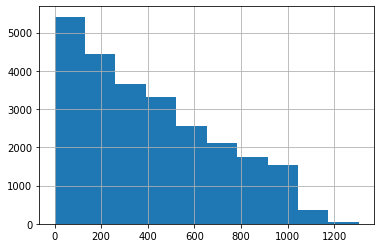

In [ ]:
ax = df['irradiation'].hist()
plt.show()

#### snip

In [ ]:
get_stats(df,'snip')

,snip Statistics
Max,1068.10
Min,0.00
Mean,492.30
Median,562.45


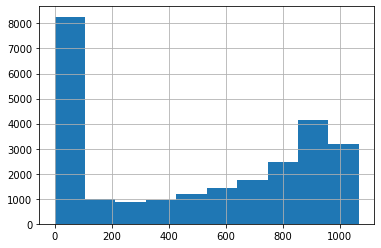

In [ ]:
df['snip'].hist()
plt.show()

#### azimuth

In [ ]:
get_stats(df, 'azimuth')

,azimuth Statistics
Max,298.55
Min,62.20
Mean,180.38
Median,180.88


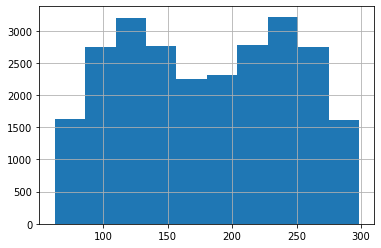

In [ ]:
df['azimuth'].hist()
plt.show()

#### temperature

In [ ]:
get_stats(df, 'temperature')

,temperature Statistics
Max,36.07
Min,-15.37
Mean,15.38
Median,16.52


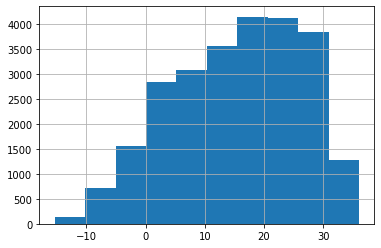

In [ ]:
df['temperature'].hist()
plt.show()

#### wet_bulb_temperature

In [ ]:
get_stats(df,'wet_bulb_temperature')

,wet_bulb_temperature Statistics
Max,19.34
Min,-16.16
Mean,6.61
Median,7.18


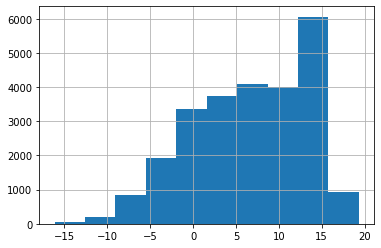

In [ ]:
df['wet_bulb_temperature'].hist()
plt.show()

#### dew_point

In [ ]:
get_stats(df,'dew_point')

,dew_point Statistics
Max,16.97
Min,-22.79
Mean,-2.07
Median,-2.41


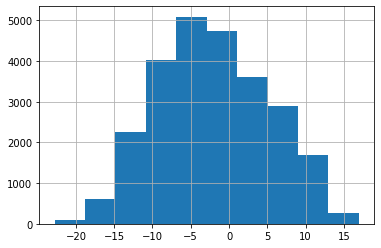

In [ ]:
df['dew_point'].hist()
plt.show()

#### rh

In [ ]:
get_stats(df,'rh')

,rh Statistics
Max,100.10
Min,4.21
Mean,35.45
Median,28.80


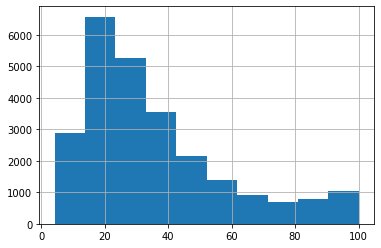

In [ ]:
df['rh'].hist()
plt.show()

#### cloud_cover

In [ ]:
get_stats(df,'cloud_cover')

,cloud_cover Statistics
Max,100.00
Min,0.00
Mean,48.64
Median,40.00


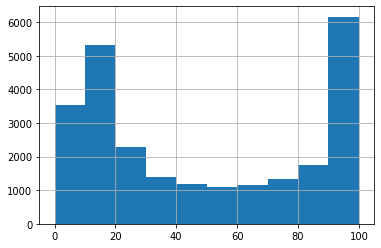

In [ ]:
df.query('cloud_cover > -1')['cloud_cover'].hist()
plt.show()

#### wind_speed

In [ ]:
get_stats(df,'wind_speed')

,wind_speed Statistics
Max,22.95
Min,0.00
Mean,3.07
Median,2.70


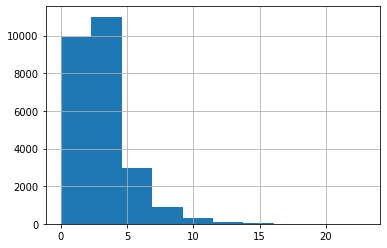

In [ ]:
df['wind_speed'].hist()
plt.show()

#### wind_direction

In [ ]:
get_stats(df,'wind_direction')

,wind_direction Statistics
Max,359.90
Min,0.00
Mean,134.65
Median,112.40


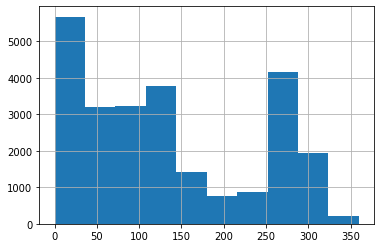

In [ ]:
df['wind_direction'].hist()
plt.show()

#### pressure

In [ ]:
get_stats(df,'pressure')

,pressure Statistics
Max,847.96
Min,799.88
Mean,816.83
Median,817.22


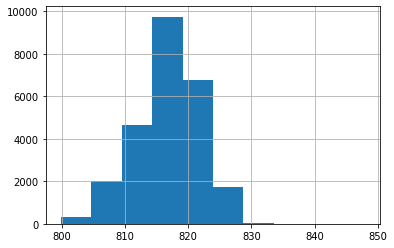

In [ ]:
df['pressure'].hist()
plt.show()

#### precipitation

In [ ]:
get_stats(df,'precipitation')

,precipitation Statistics
Max,28.19
Min,0.00
Mean,0.36
Median,0.00


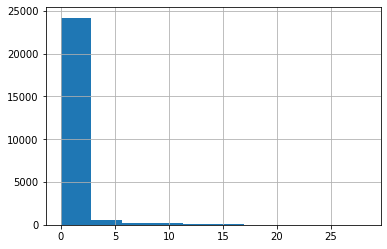

In [ ]:
df['precipitation'].hist()
plt.show()

#### snow_depth

In [ ]:
get_stats(df,'snow_depth')

,snow_depth Statistics
Max,26.32
Min,0.00
Mean,1.62
Median,0.77


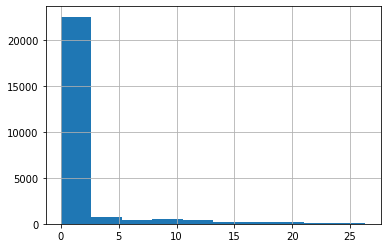

In [ ]:
df['snow_depth'].hist()
plt.show()

#### moisture

In [ ]:
get_stats(df,'moisture')

,moisture Statistics
Max,1.00
Min,0.00
Mean,0.06
Median,0.00


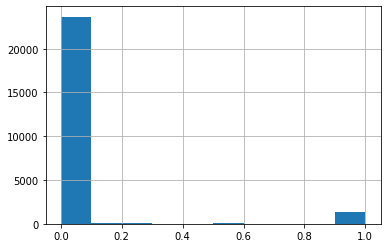

In [ ]:
df['moisture'].hist()
plt.show()

#### albedo

In [ ]:
get_stats(df,'albedo')

,albedo Statistics
Max,2.00
Min,0.00
Mean,0.27
Median,0.20


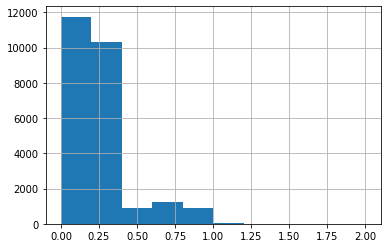

In [ ]:
df['albedo'].hist()
plt.show()

#### Correlações

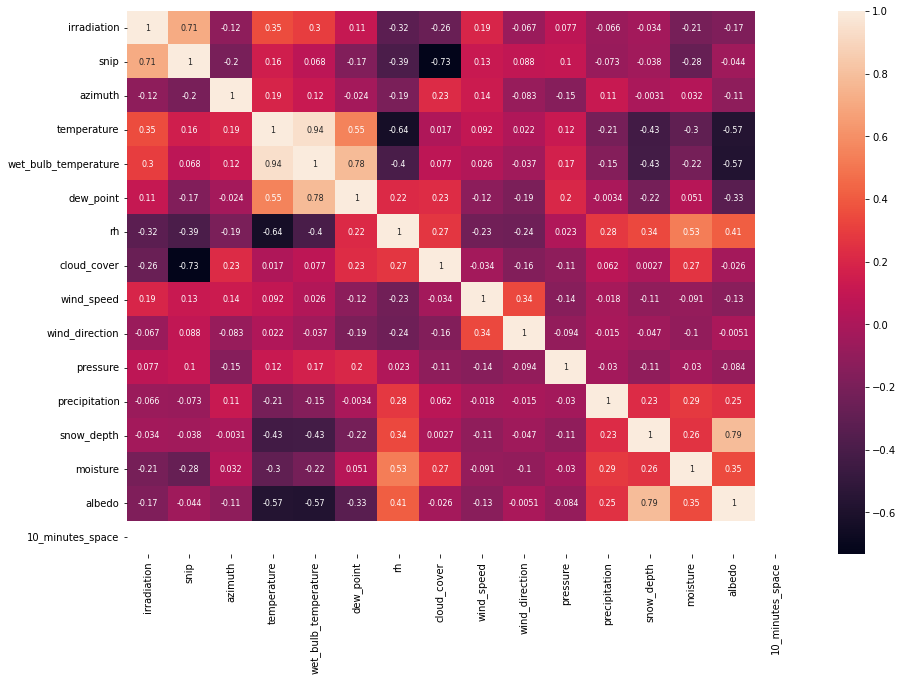

In [ ]:
# O código abaixo plota a correlação das variáveis presentes no conjunto de dados

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(df.corr(), annot = True, ax = ax, annot_kws = {'fontsize':8})
plt.show()

### Variável Alvo

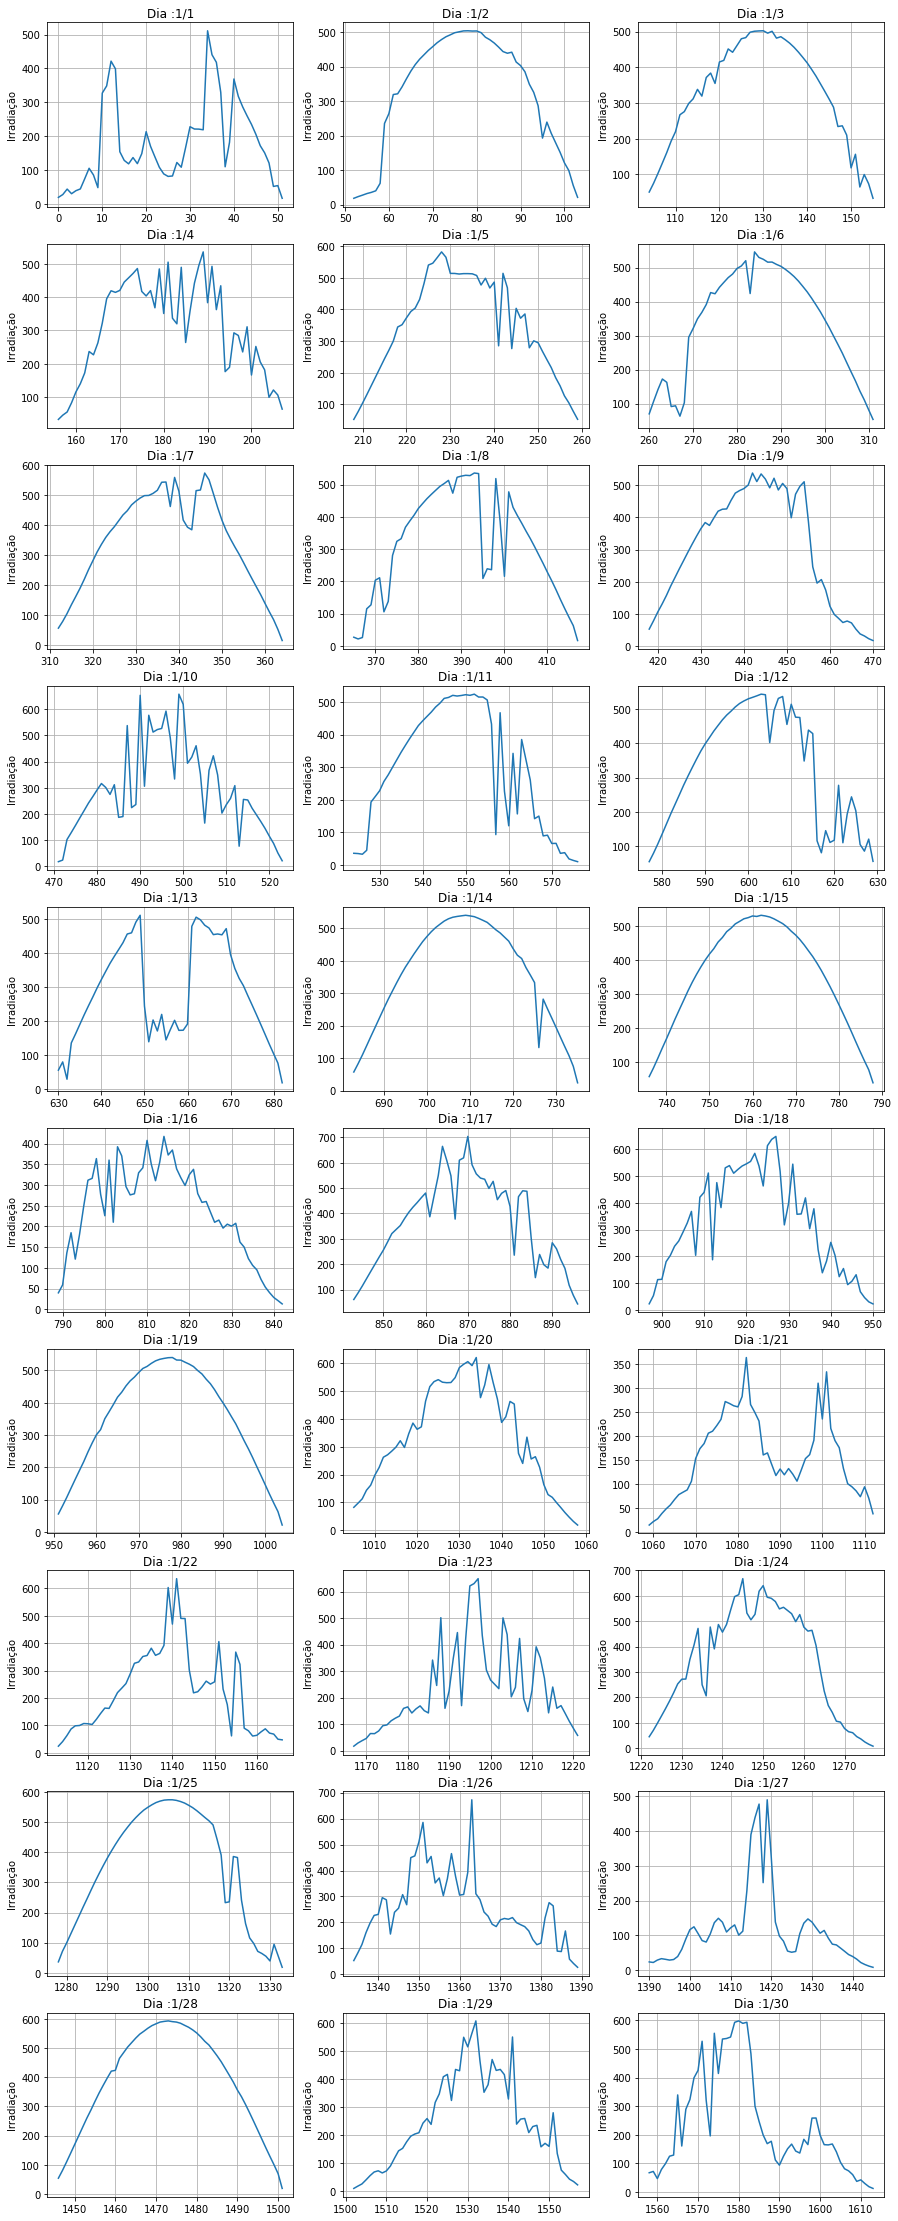

In [ ]:
# O código abaixo plota uma amostra do comportamento da irradiação de cada dia do mês de Janeiro

fig = plt.figure(figsize = (15,40))
specs = plt.GridSpec(nrows = 10, ncols = 3)

days = df['month_day'].unique()

for spec, i in zip(specs, range(0,31)):

  mask = df['month_day'] == days[i]

  ax = fig.add_subplot(spec)
  ax.plot(df.loc[mask,'irradiation'])
  ax.grid(axis='y')
  ax.grid(axis='x')
  ax.set_title('Dia :{}'.format(days[i]))
  ax.set_ylabel('Irradiação')

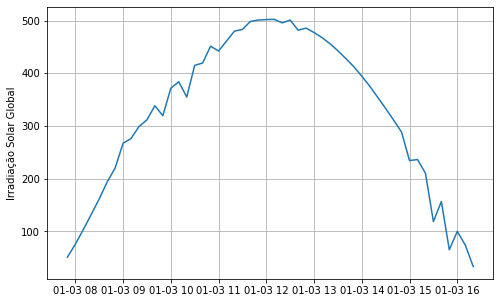

In [ ]:
# O código abaixo plota uma amostra do comportamento da irradiação de cada dia do mês de Janeiro

mask = df['month_day'] == '1/3'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
ax.plot(df.loc[mask, 'date'], df.loc[mask, 'irradiation'],)
ax.set_ylabel('Irradiação Solar Global')
ax.grid(axis='y')
ax.grid(axis='x')



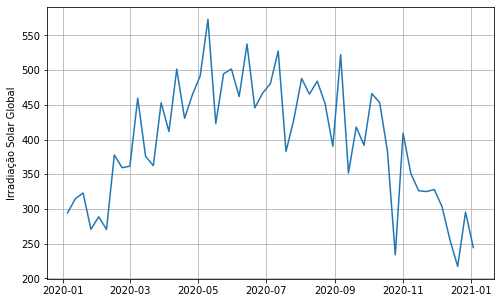

In [ ]:
# O código abaixo plota o comportamento semanl médio da irradiação solar ao longo de um ano.

df_grouped = df.groupby(by = pd.Grouper(key = 'date', freq = 'W')).mean()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5))
ax.plot(df_grouped['irradiation'])
ax.set_ylabel('Irradiação Solar Global')
ax.grid(axis='y')
ax.grid(axis='x')

## Extração de Features e Pré-processamento

In [ ]:
# A função abaixo recebe um array numpy e devolve o mesmo array rearranjado de forma a atender ao formado de dados que 
# o modelo precisará receber. (batches, número de variáveis, número de janelas de tempo)

#[[[v1, v2, v3], [v1, v2, v3], [v1, v2, v3]],
#[[v1, v2, v3], [v1, v2, v3], [v1, v2, v3]],
#[[v1, v2, v3], [v1, v2, v3], [v1, v2, v3]]]

def set_window(data, month_day, window = 6, shift = 1, padding = True):

  X = []
  y = []
  date_reference = []
  
  unique_day_list = pd.Series(month_day)
  unique_day_list = unique_day_list.drop_duplicates().values

  for day in unique_day_list:

    mask = month_day == day
    
    data_slice = data[mask,:]
    
    if padding == True:
      zeros = np.zeros(shape = (window + shift -1, data.shape[1]))
      data_slice = np.concatenate((zeros, data_slice), axis = 0)

    for i in range(len(data_slice) - window - shift + 1):

      row = [v for v in data_slice[i:i+window]]
      label = data_slice[i + window + shift - 1, 0]
      X.append(row)
      y.append(label)
      date_reference.append(day)

  return np.array(X), np.array(y), np.array(date_reference)


In [ ]:
# A função abaixo realiza a normalização em um dataframe separando as variáveis X
# das variáveis y

def scale_df(df, y_label, scaler_x = None, scaler_y = None):
  
  if scaler_x is None: 
    scaler_x = StandardScaler()
    scaler_x.fit(df.loc[:,df.columns != y_label])
  else:
    scaler_x = scaler_x
  
  if scaler_y is None:
    scaler_y = StandardScaler()
    scaler_y.fit(df[[y_label]])
  else:
    scaler_y = scaler_y

  scaled_x = scaler_x.transform(df.loc[:,df.columns != y_label])
  scaled_y = scaler_y.transform(df[[y_label]])

  data = np.concatenate((scaled_y, scaled_x), axis = 1)
  data = pd.DataFrame(data, columns = df.columns)

  return data, scaler_x, scaler_y

In [ ]:
# O código abaixo retorna um Data Frame com as colunas selecionadas conforme parâmetro 
# selected_columns

def select_columns(df, selected_columns):

  df = df[selected_columns]

  return df

In [ ]:
# O código abaixo extrai o seno e cosseno da variável date de forma a capturar a natureza cíclica do tempo.

df['seconds'] = df['date'].map(pd.Timestamp.timestamp)

day = 60*60*24
year = day*365.2425

df['day_sin'] = np.sin(df['seconds'] * (2*np.pi/day))
df['day_cos'] = np.cos(df['seconds'] * (2*np.pi/day))
df['year_sin'] = np.sin(df['seconds'] * (2*np.pi/year))
df['year_cos'] = np.cos(df['seconds'] * (2*np.pi/year))

In [ ]:
# O código abaixo extrai o seno e cosseno da variável date de forma a capturar a natureza cíclica da variável azimuth

df['azimuth_sin'] = np.sin(np.radians(df['azimuth']))
df['azimuth_cos'] = np.cos(np.radians(df['azimuth']))

In [ ]:
# O código abaixo combina as variáveis de direção do vento e velocidade do vento na criação de um vetor de vento.

df['max_wy'] = np.sin(np.radians(df['wind_direction'])) * df['wind_speed']
df['max_wx'] = np.cos(np.radians(df['wind_direction'])) * df['wind_speed']

In [ ]:
# O código abaixo faz a divisão do Data Frame em treino, validação e teste
# train - jan a set
# test - nov a dez


mask_train = (df['date'] < "2020-11-01")
mask_test = (df['date'] >= "2020-11-01")

df_train = df.loc[mask_train,:]
df_test = df.loc[mask_test,:]

df_train_date = df.loc[mask_train, 'date'].reset_index()
df_test_date = df.loc[mask_test, 'date'].reset_index()

month_day_train = df_train['month_day'].values
month_day_test = df_test['month_day'].values

print("Train DataFrame shape: {}".format(df_train.shape))
print("Test DataFrame shape: {}".format(df_test.shape))

Train DataFrame shape: (21969, 28)
Test DataFrame shape: (3267, 28)


In [ ]:
# O código abaixo selecionas as variáveis do Data Frame que serão utilizadas no treinamento do modelo

selected_columns = [#'month_day',
                    #'hour_minutes',
                    'irradiation',
                    'snip', 
                    #'azimuth',
                    'temperature',
                    'wet_bulb_temperature',
                    'dew_point',
                    'rh',
                    'cloud_cover',
                    #'wind_speed',
                    #'wind_direction',
                    'pressure',
                    'precipitation',
                    'snow_depth',
                    'moisture',
                    'albedo',
                    #'date',
                    #'10_minutes_space',
                    'day_cos',
                    'day_sin',
                    'year_sin',
                    'year_cos',
                    'azimuth_sin', 
                    'azimuth_cos',
                    'max_wy', 
                    'max_wx',
                    #'hour',
                    #'minute',
                    #'day'
                    ]

df_train = select_columns(df_train, selected_columns)
df_test = select_columns(df_test, selected_columns)

print("Train DataFrame shape: {}".format(df_train.shape))
print("Test DataFrame shape: {}".format(df_test.shape))

Train DataFrame shape: (21969, 20)
Test DataFrame shape: (3267, 20)


In [ ]:
# O código abaixo normaliza as variáveis do Data Frame

data_train, scaler_x, scaler_y = scale_df(df_train , y_label='irradiation')
data_test, _, _ = scale_df(df_test , y_label='irradiation', scaler_x = scaler_x, scaler_y = scaler_y)

print("Train array shape: {}".format(data_train.shape))
print("Test array shape: {}".format(data_test.shape))

Train array shape: (21969, 20)
Test array shape: (3267, 20)


In [ ]:
# O código abaixo transforma as variáveis de forma que seja possível treinarmos a rede neural

X_train, y_train, month_day_train = set_window(data_train.values, month_day = month_day_train, window = 12, shift = 6, padding=True)
X_test, y_test, month_day_test = set_window(data_test.values, month_day = month_day_test, window = 12, shift = 6, padding=True)

print("Train data shape: {}".format((X_train.shape, y_train.shape)))
print("Test array data: {}".format((X_test.shape, y_test.shape)))

Train data shape: ((21969, 12, 20), (21969,))
Test array data: ((3267, 12, 20), (3267,))


## Criação do Pipeline de Dados

In [ ]:
def make_pipe(X, y):
  data_set = tf.data.Dataset.from_tensor_slices((X,y))
  data_set = data_set.cache()
  data_set = data_set.batch(32)
  data_set = data_set.prefetch(8)
  return data_set

In [ ]:
ds_train = make_pipe(X_train, y_train)
ds_test = make_pipe(X_test, y_test)

In [ ]:
print("Train data batches: {}".format(len(ds_train)))
print("Test array batches: {}".format(len(ds_test)))

Train data batches: 687
Test array batches: 103


## Modelagem

In [ ]:
# A função abaixo realiza a plotagem do histórico de treinamento do modelo

def plot_history(hist):  
  history = hist.history

  fig, axs = plt.subplots(nrows=1 , ncols=2 , figsize = (10,5))

  axs[0].plot(history['loss'], label = 'train loss')
  axs[0].plot(history['val_loss'], label = 'validation loss')
  axs[0].legend()
  
  axs[1].plot(history['mean_absolute_error'], label = 'train mae')
  axs[1].plot(history['val_mean_absolute_error'], label = 'validation mae')
  axs[1].legend()
                    
  return axs


In [ ]:
 # A função abaixo calcula o erro médio absoluto do modelo

def model_score(model, X, y_true, scaler_y):
  
  predictions = model.predict(X)
  predictions = scaler_y.inverse_transform(predictions)
  
  y_true = np.expand_dims(y_true, axis = 1)
  true = scaler_y.inverse_transform(y_true)
  
  score = mean_absolute_error(true, predictions)
  
  print("Mean Absolute Error: %.2f"%score)

  return score, predictions, true


In [ ]:
# A função abaixo apresenta o erro médio quadrático

def model_score_2(model, X, y_true, scaler_y):
  
  predictions = model.predict(X)
  predictions = scaler_y.inverse_transform(predictions)
  
  y_true = np.expand_dims(y_true, axis = 1)
  true = scaler_y.inverse_transform(y_true)
  
  score = mean_squared_error(true, predictions, squared = False)
  
  print("Mean Squared Error: %.2f"%score)

  return score, predictions, true

In [ ]:
# A função abaixo apresenta o coeficiente de determinação

def model_score_3(model, X, y_true, scaler_y):
  
  predictions = model.predict(X)
  predictions = scaler_y.inverse_transform(predictions)
  
  y_true = np.expand_dims(y_true, axis = 1)
  true = scaler_y.inverse_transform(y_true)
  
  score = r2_score(true, predictions)
  
  print("R2 score: %.2f"%score)

  return score, predictions, true

In [ ]:
# A função abaixo treina o modelo com várias inicializações

def mult_init_model_tester(get_model, learning_rate, train_data, test_data, epochs, scaler_y):

  seeds = np.linspace(0,10, endpoint=False, num = 10)
  results = pd.DataFrame({'train_score':[], 'test_score':[], 'history':[]})
  

  for seed in seeds:

    print(seed)
    tf.random.set_seed(seed)
    model = get_model()

    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])
    hist = model.fit(train_data[0], train_data[1], epochs = epochs, validation_data = test_data, verbose = 0)

    history = hist.history

    train_score , _, _ = model_score(model, train_data[0], train_data[1], scaler_y)
    test_score, _, _ = model_score(model, test_data[0], test_data[1], scaler_y)

    result = pd.DataFrame({'train_score':train_score, 'test_score':test_score, 'history':[history]})

    results = pd.concat([results, result])
  
  return results

### Linha de Base

In [ ]:
# A função abaixo define o modelo linha de base.
# Este modelo irá adotar a previsão como sendo a observação da hora anterior.

def base_line_model(df):

  predictions = []

  grouped_df = df[['irradiation', 'month_day']].groupby(by='month_day')
  
  for day, group in grouped_df:
    group['predictions'] = group['irradiation'].shift(6)
    predictions.append(group)

  predictions = pd.concat(predictions)
  predictions = predictions.dropna()

  return predictions  


In [ ]:
# O código abaixo faz a divisão do Data Frame em treino, validação e teste para o modelo linha de base
# train - jan a set
# test - nov a dez

mask_train = (df['date'] < "2020-11-01")
mask_test = (df['date'] >= "2020-11-01")

df_train_bl = df.loc[mask_train,:]
df_test_bl = df.loc[mask_test,:]

print("Train DataFrame shape: {}".format(df_train_bl.shape))
print("Test DataFrame shape: {}".format(df_test_bl.shape))

Train DataFrame shape: (21969, 28)
Test DataFrame shape: (3267, 28)


In [ ]:
# O código abaixo realiza as previsões para o modelo linha de base.

predictions_train = base_line_model(df_train_bl)
predictions_test = base_line_model(df_test_bl)

In [ ]:
# O código abaixo exibe o desempenho do modelo linha de base.

print('Linha de Base treino: {}'.format(mean_absolute_error(predictions_train['irradiation'], predictions_train['predictions'])))
print('Linha de Base teste: {}'.format(mean_absolute_error(predictions_test['irradiation'], predictions_test['predictions'])))

Linha de Base treino: 175.44679858231058
Linha de Base teste: 110.17306729403654


### Modelo - 1

In [ ]:
def get_model_1():

  input = tf.keras.Input(shape=(12,20))

  x = tfl.LSTM(units = 64)(input)

  x = tfl.Dense(units = 128, activation = 'relu')(x)
  x = tfl.Dropout(0.3)(x)

  output = tfl.Dense(units = 1, activation='linear')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'lstm_model')

  return model

In [ ]:
model_1 = get_model_1()
model_1.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 20)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                21760     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,209
Trainable params: 30,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model_1.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_1 = model_1.fit(ds_train, epochs = 200, validation_data = ds_test)

Epoch 1/200
687/687 [==============================] - 8s 9ms/step - loss: 0.3541 - mean_absolute_error: 0.4406 - val_loss: 0.2028 - val_mean_absolute_error: 0.3790
Epoch 2/200
687/687 [==============================] - 6s 8ms/step - loss: 0.2876 - mean_absolute_error: 0.3800 - val_loss: 0.1080 - val_mean_absolute_error: 0.2614
Epoch 3/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2722 - mean_absolute_error: 0.3635 - val_loss: 0.0959 - val_mean_absolute_error: 0.2451
Epoch 4/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2633 - mean_absolute_error: 0.3545 - val_loss: 0.0805 - val_mean_absolute_error: 0.2170
Epoch 5/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2590 - mean_absolute_error: 0.3492 - val_loss: 0.0868 - val_mean_absolute_error: 0.2294
Epoch 6/200
687/687 [==============================] - 6s 8ms/step - loss: 0.2544 - mean_absolute_error: 0.3437 - val_loss: 0.0801 - val_mean_absolute_error: 0.2153
Epoch 7/20

In [ ]:
model_1.save('/content/drive/MyDrive/TCC Data Science/models/model_1')
history_model_1 = pd.DataFrame(hist_1.history)
history_model_1.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_1.pkl')

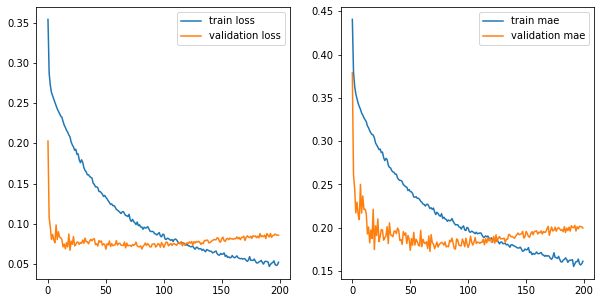

In [ ]:
ax = plot_history(hist_1)
plt.show()

In [ ]:
mdl_1_train_score , train_predictions, train_true = model_score(model_1, X_train, y_train, scaler_y)
mdl_1_test_score , test_predictions, test_true = model_score(model_1, X_test, y_test, scaler_y)

Mean Absolute Error: 42.73
Mean Absolute Error: 61.25


In [ ]:
mdl_1_train_score_2 , train_predictions, train_true = model_score_2(model_1, X_train, y_train, scaler_y)
mdl_1_test_score_2 , test_predictions, test_true = model_score_2(model_1, X_test, y_test, scaler_y)

Mean Squared Error: 62.94
Mean Squared Error: 89.87


#### Ajuste do Modelo

Devido ao fato do modelo estar sofrendo com overfitting iremos retrina-lo novamente contudo o treino será interrompido quando os valores de da função de perda for similar tanto para o conjunto de treino quanto para o conjunto de teste.

In [ ]:
history_model_1 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_1.pkl')
history_model_1['abs_diff'] = np.absolute(history_model_1['loss'] - history_model_1['val_loss'])
mask = history_model_1['abs_diff'] == history_model_1['abs_diff'].min()
history_model_1[mask]

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,abs_diff
113,0.075903,0.189067,0.075953,0.186766,0.00005


O número de épocas de treino onde o modelo apresentou menor diferênça entre os valores no conjunto de treino e teste foi 113. Treinaremos o modelo novamente considerando este número.

In [ ]:
model_1_1 = get_model_1()

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model_1_1.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

hist_1_1 = model_1_1.fit(ds_train, epochs = 113, validation_data = ds_test)

model_1_1.save('/content/drive/MyDrive/TCC Data Science/models/model_1_1')
history_model_1_1 = pd.DataFrame(hist_1_1.history)
history_model_1_1.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_1_1.pkl')

Epoch 1/113
687/687 [==============================] - 9s 10ms/step - loss: 0.3569 - mean_absolute_error: 0.4421 - val_loss: 0.0757 - val_mean_absolute_error: 0.1985
Epoch 2/113
687/687 [==============================] - 7s 10ms/step - loss: 0.2847 - mean_absolute_error: 0.3767 - val_loss: 0.0777 - val_mean_absolute_error: 0.2057
Epoch 3/113
687/687 [==============================] - 7s 10ms/step - loss: 0.2727 - mean_absolute_error: 0.3633 - val_loss: 0.0719 - val_mean_absolute_error: 0.1956
Epoch 4/113
687/687 [==============================] - 7s 10ms/step - loss: 0.2650 - mean_absolute_error: 0.3547 - val_loss: 0.0751 - val_mean_absolute_error: 0.2072
Epoch 5/113
687/687 [==============================] - 7s 10ms/step - loss: 0.2587 - mean_absolute_error: 0.3481 - val_loss: 0.0618 - val_mean_absolute_error: 0.1750
Epoch 6/113
687/687 [==============================] - 7s 10ms/step - loss: 0.2530 - mean_absolute_error: 0.3427 - val_loss: 0.0661 - val_mean_absolute_error: 0.1884
Epoc

In [ ]:
mdl_1_1_train_score , train_predictions, train_true = model_score(model_1_1, X_train, y_train, scaler_y)
mdl_1_1_test_score , test_predictions, test_true = model_score(model_1_1, X_test, y_test, scaler_y)

Mean Absolute Error: 51.47
Mean Absolute Error: 58.37


In [ ]:
mdl_1_train_score_2 , train_predictions, train_true = model_score_2(model_1_1, X_train, y_train, scaler_y)
mdl_1_test_score_2 , test_predictions, test_true = model_score_2(model_1_1, X_test, y_test, scaler_y)

Mean Squared Error: 78.40
Mean Squared Error: 84.04


#### Treino com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_1, 0.0005, (X_train, y_train), (X_test, y_test), 113, scaler_y)

0.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 44.72
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 57.07
1.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.88
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 56.84
2.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.28
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 61.57
3.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 45.10
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 62.50
4.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 45.99
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 62.59
5.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 44.32
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_1.pkl')

In [ ]:
results = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_1.pkl')

In [ ]:
results

,train_score,test_score,history
0,44.722605,57.069863,"{'loss': [0.30605918169021606, 0.2528252601623..."
0,43.883699,56.843290,"{'loss': [0.31259334087371826, 0.2532516419887..."
0,43.280508,61.565697,"{'loss': [0.30685800313949585, 0.2538145780563..."
0,45.104644,62.498152,"{'loss': [0.3176005780696869, 0.25569716095924..."
0,45.993266,62.587845,"{'loss': [0.31616291403770447, 0.2532867789268..."
0,44.316290,66.370005,"{'loss': [0.3031091094017029, 0.25435915589332..."
0,46.162781,64.879439,"{'loss': [0.31270602345466614, 0.2554300427436..."
0,44.099274,65.140278,"{'loss': [0.3085584044456482, 0.25583344697952..."
0,45.064421,60.201878,"{'loss': [0.3144504129886627, 0.25343197584152..."
0,44.243958,60.164986,"{'loss': [0.30901503562927246, 0.2548488676548..."


### Modelo - 2

In [ ]:
def get_model_2():

  input = tf.keras.Input(shape=(12,20))

  x = tfl.GRU(units = 64)(input)

  x = tfl.Dense(units = 128, activation = 'relu')(x)
  x = tfl.Dropout(0.3)(x)

  output = tfl.Dense(units = 1, activation='linear')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'GRU_model')

  return model

In [ ]:
model_2 = get_model_2()
model_2.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 20)]          0         
                                                                 
 gru (GRU)                   (None, 64)                16512     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model_2.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_2 = model_2.fit(ds_train, epochs = 200, validation_data = ds_test)

Epoch 1/200
687/687 [==============================] - 9s 10ms/step - loss: 0.3733 - mean_absolute_error: 0.4596 - val_loss: 0.1236 - val_mean_absolute_error: 0.2710
Epoch 2/200
687/687 [==============================] - 6s 9ms/step - loss: 0.3020 - mean_absolute_error: 0.3944 - val_loss: 0.0804 - val_mean_absolute_error: 0.2088
Epoch 3/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2816 - mean_absolute_error: 0.3753 - val_loss: 0.0646 - val_mean_absolute_error: 0.1739
Epoch 4/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2732 - mean_absolute_error: 0.3655 - val_loss: 0.0658 - val_mean_absolute_error: 0.1821
Epoch 5/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2661 - mean_absolute_error: 0.3572 - val_loss: 0.0783 - val_mean_absolute_error: 0.2116
Epoch 6/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2599 - mean_absolute_error: 0.3518 - val_loss: 0.0711 - val_mean_absolute_error: 0.1980
Epoch 7/2

In [ ]:
model_2.save('/content/drive/MyDrive/TCC Data Science/models/model_2')
history_model_2 = pd.DataFrame(hist_2.history)
history_model_2.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_2.pkl')

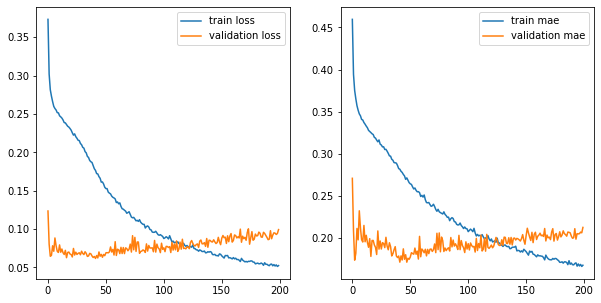

In [ ]:
ax = plot_history(hist_2)
plt.show()

In [ ]:
mdl_2_train_score , train_predictions, train_true = model_score(model_2, X_train, y_train, scaler_y)
mdl_2_test_score, test_predictions, test_true = model_score(model_2, X_test, y_test, scaler_y)

Mean Absolute Error: 43.74
Mean Absolute Error: 65.30


In [ ]:
mdl_2_train_score_2 , train_predictions, train_true = model_score_2(model_2, X_train, y_train, scaler_y)
mdl_2_val_score_2 , val_predictions, val_true = model_score_2(model_2, X_test, y_test, scaler_y)

Mean Squared Error: 61.20
Mean Squared Error: 96.75


#### Ajuste do Modelo

Devido ao fato do modelo estar sofrendo com overfitting iremos retrina-lo novamente contudo o treino será interrompido quando os valores de da função de perda for similar tanto para o conjunto de treino quanto para o conjunto de teste.

In [ ]:
history_model_2 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_2.pkl')
history_model_2['abs_diff'] = np.absolute(history_model_2['loss'] - history_model_2['val_loss'])
mask = history_model_2['abs_diff'] == history_model_2['abs_diff'].min()
history_model_2[mask]

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,abs_diff
121,0.076375,0.195527,0.076438,0.188583,0.000063


O número de épocas de treino onde o modelo apresentou menor diferênça entre os valores no conjunto de treino e teste foi 121. Treinaremos o modelo novamente considerando este número.

In [ ]:
model_2_1 = get_model_2()

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model_2_1.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

hist_2_1 = model_2_1.fit(ds_train, epochs = 121, validation_data = ds_test)

model_2_1.save('/content/drive/MyDrive/TCC Data Science/models/model_2_1')
history_model_2_1 = pd.DataFrame(hist_2_1.history)
history_model_2_1.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_2_1.pkl')

Epoch 1/121
687/687 [==============================] - 9s 10ms/step - loss: 0.3660 - mean_absolute_error: 0.4555 - val_loss: 0.1374 - val_mean_absolute_error: 0.3009
Epoch 2/121
687/687 [==============================] - 6s 9ms/step - loss: 0.3029 - mean_absolute_error: 0.4002 - val_loss: 0.0873 - val_mean_absolute_error: 0.2261
Epoch 3/121
687/687 [==============================] - 6s 9ms/step - loss: 0.2848 - mean_absolute_error: 0.3794 - val_loss: 0.0696 - val_mean_absolute_error: 0.1859
Epoch 4/121
687/687 [==============================] - 7s 10ms/step - loss: 0.2732 - mean_absolute_error: 0.3679 - val_loss: 0.0661 - val_mean_absolute_error: 0.1855
Epoch 5/121
687/687 [==============================] - 7s 10ms/step - loss: 0.2686 - mean_absolute_error: 0.3620 - val_loss: 0.0659 - val_mean_absolute_error: 0.1862
Epoch 6/121
687/687 [==============================] - 6s 9ms/step - loss: 0.2618 - mean_absolute_error: 0.3540 - val_loss: 0.0632 - val_mean_absolute_error: 0.1787
Epoch 7

In [ ]:
mdl_2_1_train_score , train_predictions, train_true = model_score(model_2_1, X_train, y_train, scaler_y)
mdl_2_1_test_score, test_predictions, test_true = model_score(model_2_1, X_test, y_test, scaler_y)

Mean Absolute Error: 54.46
Mean Absolute Error: 64.15


In [ ]:
mdl_2_1_train_score_2 , train_predictions, train_true = model_score_2(model_2_1, X_train, y_train, scaler_y)
mdl_2_1_val_score_2 , val_predictions, val_true = model_score_2(model_2_1, X_test, y_test, scaler_y)

Mean Squared Error: 78.81
Mean Squared Error: 88.78


#### Treino com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_2, 0.0005, (X_train, y_train), (X_test, y_test), 121, scaler_y)

0.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 47.27
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 62.94
1.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 46.29
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 67.60
2.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 45.28
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 60.62
3.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 44.18
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 61.86
4.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 44.95
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 61.78
5.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 44.69
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_2.pkl')

### Modelo - 3

In [ ]:
def get_model_3():

  input = tf.keras.Input(shape=(12,20))

  x = tfl.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(input)

  x = tfl.Flatten()(x)

  x = tfl.Dense(units = 128, activation = 'relu')(x)
  x = tfl.Dropout(0.3)(x)

  output = tfl.Dense(units = 1, activation='linear')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'Conv1D_model')

  return model

In [ ]:
model_3 = get_model_3()
model_3.summary()

Model: "Conv1D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 20)]          0         
                                                                 
 conv1d (Conv1D)             (None, 10, 16)            976       
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 128)               20608     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,713
Trainable params: 21,713
Non-trai

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0002)
model_3.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_3 = model_3.fit(ds_train, epochs = 200, validation_data = ds_test)

Epoch 1/200
687/687 [==============================] - 3s 3ms/step - loss: 0.6485 - mean_absolute_error: 0.6362 - val_loss: 0.2973 - val_mean_absolute_error: 0.4450
Epoch 2/200
687/687 [==============================] - 2s 3ms/step - loss: 0.4118 - mean_absolute_error: 0.4948 - val_loss: 0.2506 - val_mean_absolute_error: 0.4146
Epoch 3/200
687/687 [==============================] - 2s 3ms/step - loss: 0.3454 - mean_absolute_error: 0.4382 - val_loss: 0.2058 - val_mean_absolute_error: 0.3719
Epoch 4/200
687/687 [==============================] - 2s 3ms/step - loss: 0.3150 - mean_absolute_error: 0.4092 - val_loss: 0.1644 - val_mean_absolute_error: 0.3349
Epoch 5/200
687/687 [==============================] - 2s 3ms/step - loss: 0.2970 - mean_absolute_error: 0.3909 - val_loss: 0.1404 - val_mean_absolute_error: 0.3092
Epoch 6/200
687/687 [==============================] - 2s 3ms/step - loss: 0.2901 - mean_absolute_error: 0.3822 - val_loss: 0.1331 - val_mean_absolute_error: 0.3039
Epoch 7/20

In [ ]:
model_3.save('/content/drive/MyDrive/TCC Data Science/models/model_3')
history_model_3 = pd.DataFrame(hist_3.history)
history_model_3.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_3.pkl')

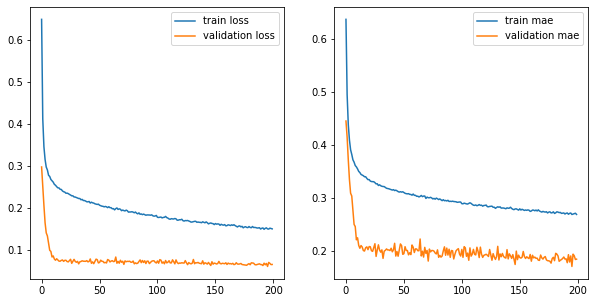

In [ ]:
ax = plot_history(hist_3)
plt.show()

In [ ]:
mdl_3_train_score , train_predictions, train_true = model_score(model_3, X_train, y_train, scaler_y)
mdl_3_test_score, test_predictions, test_true = model_score(model_3, X_test, y_test, scaler_y)

Mean Absolute Error: 67.94
Mean Absolute Error: 56.82


In [ ]:
mdl_3_train_score_2 , train_predictions, train_true = model_score_2(model_3, X_train, y_train, scaler_y)
mdl_3_test_score_2 , test_predictions, test_true = model_score_2(model_3, X_test, y_test, scaler_y)

Mean Squared Error: 102.19
Mean Squared Error: 78.38


#### Treinando com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_3, 0.0002, (X_train, y_train), (X_test, y_test), 200, scaler_y)

0.0
687/687 [==============================] - 1s 857us/step
Mean Absolute Error: 64.52
103/103 [==============================] - 0s 903us/step
Mean Absolute Error: 50.12
1.0
687/687 [==============================] - 1s 1ms/step
Mean Absolute Error: 64.32
103/103 [==============================] - 0s 894us/step
Mean Absolute Error: 60.16
2.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 63.46
103/103 [==============================] - 0s 924us/step
Mean Absolute Error: 55.28
3.0
687/687 [==============================] - 1s 918us/step
Mean Absolute Error: 65.13
103/103 [==============================] - 0s 878us/step
Mean Absolute Error: 51.27
4.0
687/687 [==============================] - 1s 902us/step
Mean Absolute Error: 63.83
103/103 [==============================] - 0s 985us/step
Mean Absolute Error: 61.54
5.0
687/687 [==============================] - 1s 906us/step
Mean Absolute Error: 64.67
103/103 [==============================] - 0s 1ms/step
M

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_3.pkl')

### Modelo - 4

In [ ]:
def get_model_4():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.LSTM(units = 64)(input_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'LSTM_two_inputs')

  return model

In [ ]:
model_4 = get_model_4()
model_4.summary()

Model: "LSTM_two_inputs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 20)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           21760       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 70)           0           ['lstm[0][0]',                   
                                                                  'input_2[0][0]']  

In [ ]:
# Cria as variáveis do Input 2

selected_columns = [
                    'day_sin',
                    'day_cos',
                    'year_sin',
                    'year_cos',
                    'azimuth_sin', 
                    'azimuth_cos',
                    ]

data_train_time = select_columns(data_train, selected_columns)
data_test_time = select_columns(data_test, selected_columns)

data_train_time = data_train_time.values
data_test_time = data_test_time.values

print("Train data shape: {}".format(data_train_time.shape))
print("Test array data: {}".format(data_test_time.shape))

Train data shape: (21969, 6)
Test array data: (3267, 6)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0002)
model_4.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_4 = model_4.fit({'input_1':X_train, 'input_2':data_train_time} , y_train, batch_size=32, epochs = 200, validation_data = ([X_test, data_test_time], y_test))

Epoch 1/200
687/687 [==============================] - 9s 10ms/step - loss: 0.3242 - mean_absolute_error: 0.4149 - val_loss: 0.0717 - val_mean_absolute_error: 0.1975
Epoch 2/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2692 - mean_absolute_error: 0.3610 - val_loss: 0.0565 - val_mean_absolute_error: 0.1601
Epoch 3/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2556 - mean_absolute_error: 0.3467 - val_loss: 0.0552 - val_mean_absolute_error: 0.1612
Epoch 4/200
687/687 [==============================] - 7s 10ms/step - loss: 0.2500 - mean_absolute_error: 0.3383 - val_loss: 0.0581 - val_mean_absolute_error: 0.1702
Epoch 5/200
687/687 [==============================] - 7s 10ms/step - loss: 0.2423 - mean_absolute_error: 0.3309 - val_loss: 0.0530 - val_mean_absolute_error: 0.1564
Epoch 6/200
687/687 [==============================] - 6s 9ms/step - loss: 0.2367 - mean_absolute_error: 0.3263 - val_loss: 0.0524 - val_mean_absolute_error: 0.1538
Epoch 7

In [ ]:
model_4.save('/content/drive/MyDrive/TCC Data Science/models/model_4')
history_model_4 = pd.DataFrame(hist_4.history)
history_model_4.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_4.pkl')

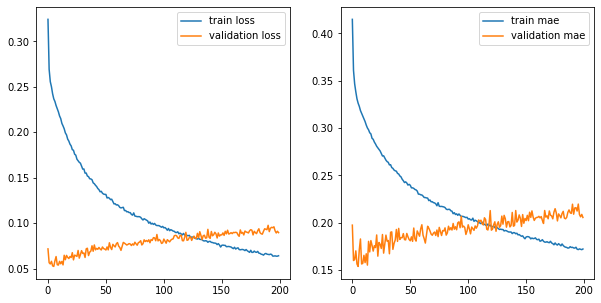

In [ ]:
ax = plot_history(hist_4)
plt.show()

In [ ]:
mdl_4_train_score , train_predictions, train_true = model_score(model_4, [X_train, data_train_time], y_train, scaler_y)
mdl_4_test_score, test_predictions, test_true = model_score(model_4, [X_test, data_test_time], y_test, scaler_y)

Mean Absolute Error: 44.38
Mean Absolute Error: 63.08


In [ ]:
mdl_4_train_score_2 , train_predictions, train_true = model_score_2(model_4, [X_train, data_train_time], y_train, scaler_y)
mdl_4_test_score_2 , test_predictions, test_true = model_score_2(model_4, [X_test, data_test_time], y_test, scaler_y)

Mean Squared Error: 68.60
Mean Squared Error: 91.87


#### Ajuste do Modelo

Devido ao fato do modelo estar sofrendo com overfitting iremos retrina-lo novamente contudo o treino será interrompido quando os valores de da função de perda for similar tanto para o conjunto de treino quanto para o conjunto de teste.

In [ ]:
history_model_4 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_4.pkl')
history_model_4['abs_diff'] = np.absolute(history_model_4['loss'] - history_model_4['val_loss'])
mask = history_model_4['abs_diff'] == history_model_4['abs_diff'].min()
history_model_4[mask]

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,abs_diff
133,0.08191,0.19153,0.081943,0.195272,0.000033


O número de épocas de treino onde o modelo apresentou menor diferênça entre os valores no conjunto de treino e teste foi 133. Treinaremos o modelo novamente considerando este número.

In [ ]:
model_4_1 = get_model_4()

adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model_4_1.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

hist_4_1 = model_4_1.fit({'input_1':X_train, 'input_2':data_train_time} , y_train, batch_size=32, epochs = 133, validation_data = ([X_test, data_test_time], y_test))

model_4_1.save('/content/drive/MyDrive/TCC Data Science/models/model_4_1')
history_model_4_1 = pd.DataFrame(hist_4_1.history)
history_model_4_1.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_4_1.pkl')

Epoch 1/133
687/687 [==============================] - 10s 11ms/step - loss: 0.2989 - mean_absolute_error: 0.3886 - val_loss: 0.0638 - val_mean_absolute_error: 0.1890
Epoch 2/133
687/687 [==============================] - 7s 10ms/step - loss: 0.2529 - mean_absolute_error: 0.3424 - val_loss: 0.0616 - val_mean_absolute_error: 0.1813
Epoch 3/133
687/687 [==============================] - 7s 10ms/step - loss: 0.2429 - mean_absolute_error: 0.3328 - val_loss: 0.0537 - val_mean_absolute_error: 0.1610
Epoch 4/133
687/687 [==============================] - 7s 10ms/step - loss: 0.2323 - mean_absolute_error: 0.3224 - val_loss: 0.0569 - val_mean_absolute_error: 0.1702
Epoch 5/133
687/687 [==============================] - 7s 10ms/step - loss: 0.2255 - mean_absolute_error: 0.3169 - val_loss: 0.0518 - val_mean_absolute_error: 0.1535
Epoch 6/133
687/687 [==============================] - 7s 10ms/step - loss: 0.2202 - mean_absolute_error: 0.3108 - val_loss: 0.0549 - val_mean_absolute_error: 0.1606
Epo

In [ ]:
mdl_4_1_train_score , train_predictions, train_true = model_score(model_4_1, [X_train, data_train_time], y_train, scaler_y)
mdl_4_1_test_score, test_predictions, test_true = model_score(model_4_1, [X_test, data_test_time], y_test, scaler_y)

Mean Absolute Error: 40.87
Mean Absolute Error: 56.28


In [ ]:
mdl_4_1_train_score_2 , train_predictions, train_true = model_score_2(model_4_1, [X_train, data_train_time], y_train, scaler_y)
mdl_4_1_val_score_2 , val_predictions, val_true = model_score_2(model_4_1, [X_test, data_test_time], y_test, scaler_y)

Mean Squared Error: 63.04
Mean Squared Error: 83.81


#### Treinando com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_4, 0.0002, ([X_train, data_train_time], y_train), ([X_test, data_test_time], y_test), 133, scaler_y)

0.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.23
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 55.82
1.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.39
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 56.38
2.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 44.02
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 60.28
3.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 44.10
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 57.34
4.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.52
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 59.05
5.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 43.43
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_4.pkl')

### Modelo - 5

In [ ]:
def get_model_5():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.GRU(units = 64)(input_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'GRU_two_inputs')

  return model

In [ ]:
model_5 = get_model_5()
model_5.summary()

Model: "GRU_two_inputs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 20)]     0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 64)           16512       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 70)           0           ['gru_2[0][0]',                  
                                                                  'input_2[0][0]']   

In [ ]:
# Cria as variáveis do Input 2

selected_columns = [
                    'day_sin',
                    'day_cos',
                    'year_sin',
                    'year_cos',
                    'azimuth_sin', 
                    'azimuth_cos',
                    ]

data_train_time = select_columns(data_train, selected_columns)
data_test_time = select_columns(data_test, selected_columns)

data_train_time = data_train_time.values
data_test_time = data_test_time.values

print("Train data shape: {}".format(data_train_time.shape))
print("Test array data: {}".format(data_test_time.shape))

Train data shape: (21969, 6)
Test array data: (3267, 6)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0002)
model_5.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_5 = model_5.fit({'input_1':X_train, 'input_2':data_train_time} , y_train, batch_size=32, epochs = 200, validation_data = ([X_test, data_test_time], y_test))

Epoch 1/200
687/687 [==============================] - 11s 12ms/step - loss: 0.3533 - mean_absolute_error: 0.4373 - val_loss: 0.0708 - val_mean_absolute_error: 0.1900
Epoch 2/200
687/687 [==============================] - 8s 11ms/step - loss: 0.2753 - mean_absolute_error: 0.3696 - val_loss: 0.0599 - val_mean_absolute_error: 0.1696
Epoch 3/200
687/687 [==============================] - 8s 11ms/step - loss: 0.2624 - mean_absolute_error: 0.3533 - val_loss: 0.0589 - val_mean_absolute_error: 0.1715
Epoch 4/200
687/687 [==============================] - 8s 12ms/step - loss: 0.2542 - mean_absolute_error: 0.3444 - val_loss: 0.0559 - val_mean_absolute_error: 0.1637
Epoch 5/200
687/687 [==============================] - 8s 12ms/step - loss: 0.2509 - mean_absolute_error: 0.3393 - val_loss: 0.0491 - val_mean_absolute_error: 0.1479
Epoch 6/200
687/687 [==============================] - 8s 11ms/step - loss: 0.2441 - mean_absolute_error: 0.3336 - val_loss: 0.0512 - val_mean_absolute_error: 0.1531
Epo

In [ ]:
model_5.save('/content/drive/MyDrive/TCC Data Science/models/model_5')
history_model_5 = pd.DataFrame(hist_5.history)
history_model_5.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_5.pkl')

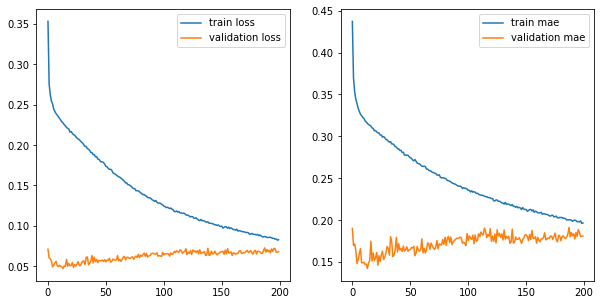

In [ ]:
ax = plot_history(hist_5)
plt.show()

In [ ]:
mdl_5_train_score , train_predictions, train_true = model_score(model_5, [X_train, data_train_time], y_train, scaler_y)
mdl_5_test_score, test_predictions, test_true = model_score(model_5, [X_test, data_test_time], y_test, scaler_y)

Mean Absolute Error: 50.66
Mean Absolute Error: 55.46


In [ ]:
mdl_5_train_score_2 , train_predictions, train_true = model_score_2(model_5, [X_train, data_train_time], y_train, scaler_y)
mdl_5_test_score_2 , test_predictions, test_true = model_score_2(model_5, [X_test, data_test_time], y_test, scaler_y)

Mean Squared Error: 79.21
Mean Squared Error: 79.95


#### Treinando com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_5, 0.0002, ([X_train, data_train_time], y_train), ([X_test, data_test_time], y_test), 200, scaler_y)

0.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 51.40
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 59.55
1.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 49.89
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 59.37
2.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 50.59
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 54.35
3.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 51.23
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 58.91
4.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 50.63
103/103 [==============================] - 0s 3ms/step
Mean Absolute Error: 58.11
5.0
687/687 [==============================] - 2s 2ms/step
Mean Absolute Error: 50.35
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_5.pkl')

### Modelo - 6

In [ ]:
def get_model_6():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(input_1)

  x_1 = tfl.Flatten()(x_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'Conv1D_two_inputs')

  return model

In [ ]:
model_6 = get_model_6()
model_6.summary()

Model: "Conv1D_two_inputs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 20)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 10, 16)       976         ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 160)          0           ['conv1d_1[0][0]']               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                  

In [ ]:
# Cria as variáveis do Input 2

selected_columns = [
                    'day_sin',
                    'day_cos',
                    'year_sin',
                    'year_cos',
                    'azimuth_sin', 
                    'azimuth_cos',
                    ]

data_train_time = select_columns(data_train, selected_columns)
data_test_time = select_columns(data_test, selected_columns)

data_train_time = data_train_time.values
data_test_time = data_test_time.values

print("Train data shape: {}".format(data_train_time.shape))
print("Test array data: {}".format(data_test_time.shape))

Train data shape: (21969, 6)
Test array data: (3267, 6)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0002)
model_6.compile(optimizer = adam, loss= 'MeanSquaredError', metrics = ['mean_absolute_error'])

In [ ]:
hist_6 = model_6.fit({'input_1':X_train, 'input_2':data_train_time} , y_train, batch_size=32, epochs = 500, validation_data = ([X_test, data_test_time], y_test))

Epoch 1/500
687/687 [==============================] - 3s 3ms/step - loss: 0.4612 - mean_absolute_error: 0.5116 - val_loss: 0.1063 - val_mean_absolute_error: 0.2604
Epoch 2/500
687/687 [==============================] - 2s 3ms/step - loss: 0.2999 - mean_absolute_error: 0.3936 - val_loss: 0.0776 - val_mean_absolute_error: 0.2058
Epoch 3/500
687/687 [==============================] - 2s 3ms/step - loss: 0.2779 - mean_absolute_error: 0.3705 - val_loss: 0.0683 - val_mean_absolute_error: 0.1862
Epoch 4/500
687/687 [==============================] - 2s 3ms/step - loss: 0.2649 - mean_absolute_error: 0.3587 - val_loss: 0.0669 - val_mean_absolute_error: 0.1846
Epoch 5/500
687/687 [==============================] - 2s 3ms/step - loss: 0.2565 - mean_absolute_error: 0.3500 - val_loss: 0.0629 - val_mean_absolute_error: 0.1760
Epoch 6/500
687/687 [==============================] - 2s 3ms/step - loss: 0.2515 - mean_absolute_error: 0.3442 - val_loss: 0.0657 - val_mean_absolute_error: 0.1801
Epoch 7/50

In [ ]:
model_6.save('/content/drive/MyDrive/TCC Data Science/models/model_6')
history_model_6 = pd.DataFrame(hist_6.history)
history_model_6.to_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_6.pkl')

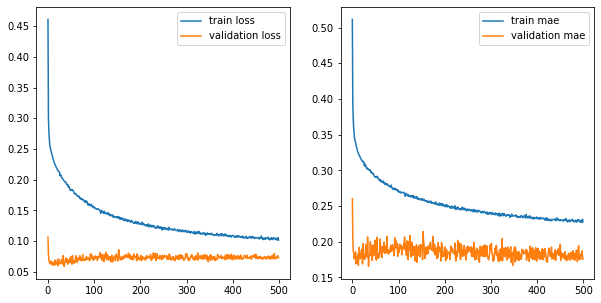

In [ ]:
ax = plot_history(hist_6)
plt.show()

In [ ]:
mdl_6_train_score , train_predictions, train_true = model_score(model_6, [X_train, data_train_time], y_train, scaler_y)
mdl_6_test_score, test_predictions, test_true = model_score(model_6, [X_test, data_test_time], y_test, scaler_y)

Mean Absolute Error: 52.74
Mean Absolute Error: 53.85


In [ ]:
mdl_6_train_score_2 , train_predictions, train_true = model_score_2(model_6, [X_train, data_train_time], y_train, scaler_y)
mdl_6_test_score_2 , test_predictions, test_true = model_score_2(model_6, [X_test, data_test_time], y_test, scaler_y)

Mean Squared Error: 76.69
Mean Squared Error: 82.76


#### Treinando com várias inicializações

In [ ]:
results = mult_init_model_tester(get_model_6, 0.0002, ([X_train, data_train_time], y_train), ([X_test, data_test_time], y_test), 500, scaler_y)

0.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 51.53
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 53.31
1.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 54.13
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 55.87
2.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 50.77
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 51.29
3.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 50.18
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 53.73
4.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 49.35
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error: 50.27
5.0
687/687 [==============================] - 1s 2ms/step
Mean Absolute Error: 51.04
103/103 [==============================] - 0s 2ms/step
Mean Absolute Error

In [ ]:
results.to_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_6.pkl')

#### Cálculo do R2

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TCC Data Science/models/model_6')

In [ ]:
mdl_6_test_score_3 , test_predictions, test_true = model_score_3(model, [X_train, data_train_time], y_train, scaler_y)
mdl_6_test_score_3 , test_predictions, test_true = model_score_3(model, [X_test, data_test_time], y_test, scaler_y)

687/687 [==============================] - 1s 2ms/step
R2 score: 0.94
103/103 [==============================] - 0s 2ms/step
R2 score: 0.78


## Gráficos TCC

In [ ]:
history_model_1 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_1.pkl')
history_model_2 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_2.pkl')
history_model_3 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_3.pkl')
history_model_4 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_4.pkl')
history_model_5 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_5.pkl')
history_model_6 = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/history/history_model_6.pkl')

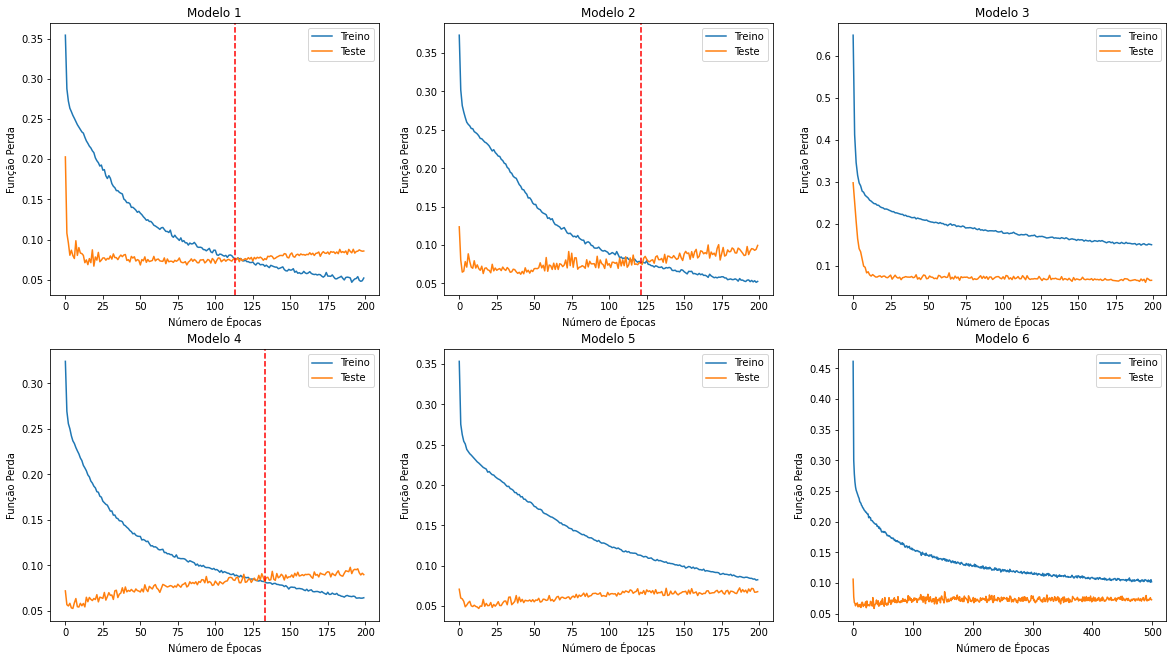

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,11))

ax[0][0].plot(history_model_1['loss'], label = 'Treino')
ax[0][0].plot(history_model_1['val_loss'], label = 'Teste')
ax[0][0].set_xlabel('Número de Épocas')
ax[0][0].set_ylabel('Função Perda')
ax[0][0].set_title('Modelo 1')
ax[0][0].legend()
ax[0][0].axvline(113, ls = '--', color = 'r')

ax[0][1].plot(history_model_2['loss'], label = 'Treino')
ax[0][1].plot(history_model_2['val_loss'], label = 'Teste')
ax[0][1].set_xlabel('Número de Épocas')
ax[0][1].set_ylabel('Função Perda')
ax[0][1].set_title('Modelo 2')
ax[0][1].legend()
ax[0][1].axvline(121, ls = '--', color = 'r')

ax[0][2].plot(history_model_3['loss'], label = 'Treino')
ax[0][2].plot(history_model_3['val_loss'], label = 'Teste')
ax[0][2].set_xlabel('Número de Épocas')
ax[0][2].set_ylabel('Função Perda')
ax[0][2].set_title('Modelo 3')
ax[0][2].legend()

ax[1][0].plot(history_model_4['loss'], label = 'Treino')
ax[1][0].plot(history_model_4['val_loss'], label = 'Teste')
ax[1][0].set_xlabel('Número de Épocas')
ax[1][0].set_ylabel('Função Perda')
ax[1][0].set_title('Modelo 4')
ax[1][0].axvline(133, ls = '--', color = 'r')
ax[1][0].legend()

ax[1][1].plot(history_model_5['loss'], label = 'Treino')
ax[1][1].plot(history_model_5['val_loss'], label = 'Teste')
ax[1][1].set_xlabel('Número de Épocas')
ax[1][1].set_ylabel('Função Perda')
ax[1][1].set_title('Modelo 5')
ax[1][1].legend()

ax[1][2].plot(history_model_6['loss'], label = 'Treino')
ax[1][2].plot(history_model_6['val_loss'], label = 'Teste')
ax[1][2].set_xlabel('Número de Épocas')
ax[1][2].set_ylabel('Função Perda')
ax[1][2].set_title('Modelo 6')
ax[1][2].legend()



In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TCC Data Science/models/model_6')
mdl_test_score , test_predictions, test_true = model_score(model, [X_test, data_test_time], y_test, scaler_y)

Mean Absolute Error: 53.85


Text(0, 0.5, 'Irradiação Global')

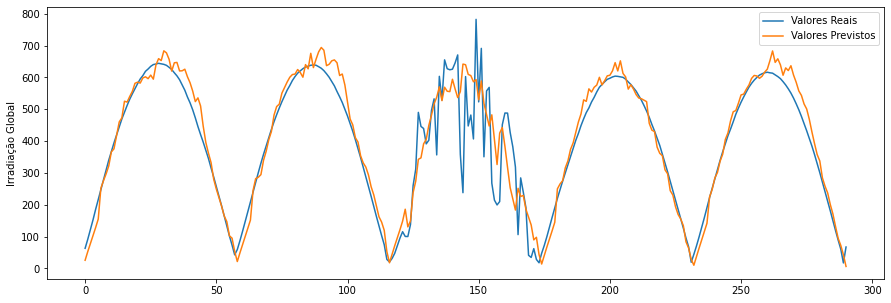

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))

ax.plot(test_true[0:291], label = 'Valores Reais')
ax.plot(test_predictions[0:291], label = 'Valores Previstos')
ax.legend()
ax.set_ylabel('Irradiação Global')

In [ ]:
mean_list = []
std_list = []

for i in range(0,6):
  log = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/project_logs/mult_{}.pkl'.format(i+1))
  mean = log['test_score'].mean()
  std = log['test_score'].std()
  mean_list.append(mean)
  std_list.append(std)

logs = pd.DataFrame({'mean':mean_list,'std':std_list})
logs

,mean,std
0,61.732143,3.245728
1,63.384864,2.967153
2,55.611423,4.130238
3,57.949422,2.163031
4,57.788541,2.590140
5,53.304434,2.350716


In [ ]:
df_g = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/dados/train_clean.pkl')
days = ["1/2", "1/3", "1/4"]

fig = make_subplots(rows = 1, cols = 3)
fig.update_layout(template = 'simple_white')

for i in range(1,4):
  mask = (df_g['month_day'] == days[i-1])
  df_g_day = df_g[mask]
  fig.add_trace(
      go.Scatter(x = df_g_day['date'], y = df_g_day['irradiation'], mode = 'lines+markers', line=dict(color="#f08a05")),
      row = 1, col = i
  )

  fig.update_xaxes(showgrid=True, mirror=True, ticks='outside',showline=True, tickformat="%H:%M\n%d %b", title_text="Horário", row = 1, col = i)
  fig.update_yaxes(showgrid=True, mirror=True, ticks='outside',showline=True, title_text="Irradiação Solar Global", row = 1, col = i)

fig.update_layout(width = 1300, showlegend = False)
fig.show()


In [ ]:
df_g = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/dados/train_clean.pkl')

df_g_grouped = df_g.groupby(by = pd.Grouper(key = 'date', freq = 'W')).mean().reset_index()
label = {'date': 'Data', 'irradiation':'Irradiância Solar Global Média'}

fig = px.line(data_frame = df_g_grouped, x = 'date', y = 'irradiation', labels = label, template='simple_white', markers = True, width = 1000)
fig.update_xaxes(showgrid=True, mirror=True, ticks='outside',showline=True, tickformat="%b")
fig.update_yaxes(showgrid=True, mirror=True, ticks='outside',showline=True)
fig.update_traces(line_color='#f08a05')


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TCC Data Science/dados/train.csv')

new_columns = {"DATE (MM/DD)":"month_day",
               "MST":"hour_minutes",
               "Global CMP22 (vent/cor) [W/m^2]":"irradiation",
               "Direct sNIP [W/m^2]":"snip",
               "Azimuth Angle [degrees]":"azimuth",
               "Tower Dry Bulb Temp [deg C]":"temperature",
               "Tower Wet Bulb Temp [deg C]":"wet_bulb_temperature",
               "Tower Dew Point Temp [deg C]":"dew_point",
               "Tower RH [%]":"rh",
               "Total Cloud Cover [%]":"cloud_cover",
               "Peak Wind Speed @ 6ft [m/s]":"wind_speed",
               "Avg Wind Direction @ 6ft [deg from N]":"wind_direction",
               "Station Pressure [mBar]":"pressure",
               "Precipitation (Accumulated) [mm]":"precipitation",
               "Snow Depth [cm]":"snow_depth",
               "Moisture":"moisture",
               "Albedo (CMP11)":"albedo"}

df = df.rename(columns = new_columns)

df['date'] = df.apply(date_transform, axis = 1)

df['seconds'] = df['date'].map(pd.Timestamp.timestamp)

day = 60*60*24
year = day*365.2425

df['day_sin'] = np.sin(df['seconds'] * (2*np.pi/day))
df['day_cos'] = np.cos(df['seconds'] * (2*np.pi/day))
df['year_sin'] = np.sin(df['seconds'] * (2*np.pi/year))
df['year_cos'] = np.cos(df['seconds'] * (2*np.pi/year))

mask = df['month_day'] == "7/7"

df = df[mask]

fig  = make_subplots(rows = 2, cols = 1)
fig.update_layout(template = 'simple_white')

fig.add_trace(go.Scatter(x = df['seconds'], y = df['day_sin']), row = 1, col = 1)
fig.update_xaxes(showgrid=True, mirror=True, ticks='outside',showline=True, tickformat=".6", row = 1, col = 1)
fig.update_yaxes(showgrid=True, mirror=True, ticks='outside',showline=True, title_text="Função Seno - f(t)", row = 1, col = 1)

fig.add_trace(go.Scatter(x = df['seconds'], y = df['day_cos']), row = 2, col = 1)
fig.update_xaxes(showgrid=True, mirror=True, ticks='outside',showline=True, tickformat=".6", title_text="Segundos", row = 2, col = 1)
fig.update_yaxes(showgrid=True, mirror=True, ticks='outside',showline=True, title_text="Função Cosseno - g(t)", row = 2, col = 1)


fig.update_layout(width = 700, showlegend = False)

fig.show()

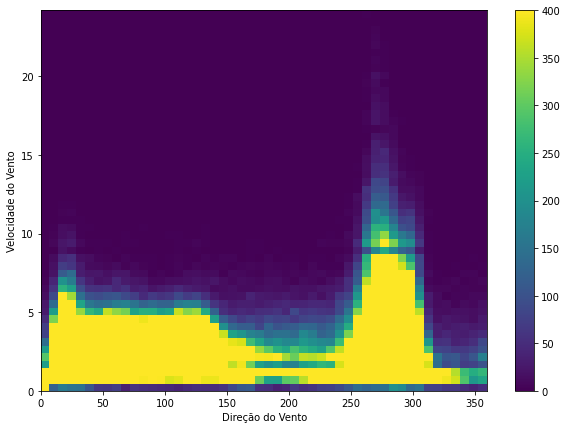

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TCC Data Science/dados/train.csv')

new_columns = {"DATE (MM/DD)":"month_day",
               "MST":"hour_minutes",
               "Global CMP22 (vent/cor) [W/m^2]":"irradiation",
               "Direct sNIP [W/m^2]":"snip",
               "Azimuth Angle [degrees]":"azimuth",
               "Tower Dry Bulb Temp [deg C]":"temperature",
               "Tower Wet Bulb Temp [deg C]":"wet_bulb_temperature",
               "Tower Dew Point Temp [deg C]":"dew_point",
               "Tower RH [%]":"rh",
               "Total Cloud Cover [%]":"cloud_cover",
               "Peak Wind Speed @ 6ft [m/s]":"wind_speed",
               "Avg Wind Direction @ 6ft [deg from N]":"wind_direction",
               "Station Pressure [mBar]":"pressure",
               "Precipitation (Accumulated) [mm]":"precipitation",
               "Snow Depth [cm]":"snow_depth",
               "Moisture":"moisture",
               "Albedo (CMP11)":"albedo"}

df = df.rename(columns = new_columns)

df['max_wy'] = np.sin(np.radians(df['wind_direction'])) * df['wind_speed']
df['max_wx'] = np.cos(np.radians(df['wind_direction'])) * df['wind_speed']

plt.figure(figsize = (10,7))
plt.hist2d(df['wind_direction'], df['wind_speed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Direção do Vento')
plt.ylabel('Velocidade do Vento')
plt.show()

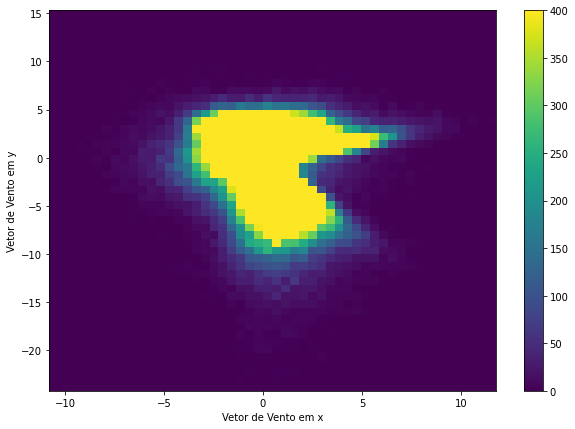

In [ ]:
plt.figure(figsize = (10,7))
plt.hist2d(df['max_wx'], df['max_wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Vetor de Vento em x')
plt.ylabel('Vetor de Vento em y')
plt.show()

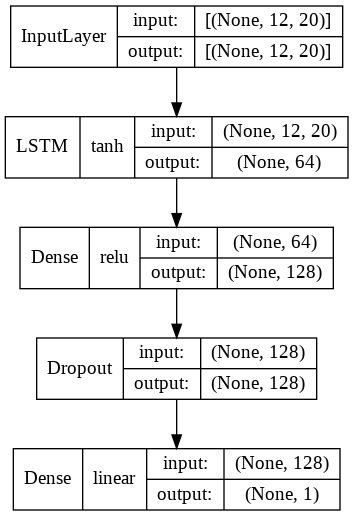

In [ ]:
def get_model_1():

  input = tf.keras.Input(shape=(12,20), name = 'input_1')

  x = tfl.LSTM(units = 64, name = 'lstm_1')(input)

  x = tfl.Dense(units = 128, activation = 'relu', name = 'dense_1')(x)
  x = tfl.Dropout(0.3, name = 'dropout_1')(x)

  output = tfl.Dense(units = 1, activation='linear', name = 'dense_2')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'lstm_model')

  return model

model_1 = get_model_1()

tf.keras.utils.plot_model(model_1, show_shapes = True, show_layer_activations = True, show_layer_names = False)

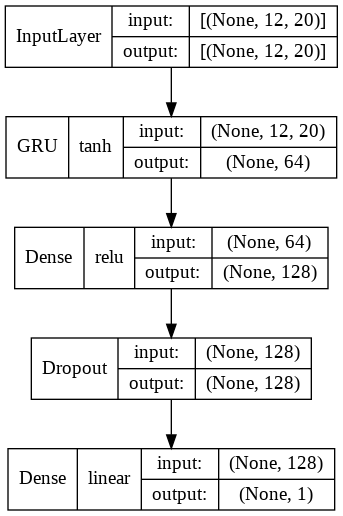

In [ ]:
def get_model_2():

  input = tf.keras.Input(shape=(12,20))

  x = tfl.GRU(units = 64)(input)

  x = tfl.Dense(units = 128, activation = 'relu')(x)
  x = tfl.Dropout(0.3)(x)

  output = tfl.Dense(units = 1, activation='linear')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'GRU_model')

  return model

model_2 = get_model_2()

tf.keras.utils.plot_model(model_2, show_shapes = True, show_layer_activations = True, show_layer_names = False)

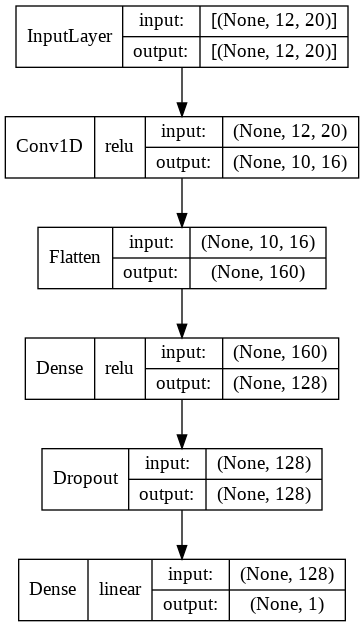

In [ ]:
def get_model_3():

  input = tf.keras.Input(shape=(12,20))

  x = tfl.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(input)

  x = tfl.Flatten()(x)

  x = tfl.Dense(units = 128, activation = 'relu')(x)
  x = tfl.Dropout(0.3)(x)

  output = tfl.Dense(units = 1, activation='linear')(x)

  model = tf.keras.Model(inputs=input, outputs=output, name = 'Conv1D_model')

  return model

model_3 = get_model_3()

tf.keras.utils.plot_model(model_3, show_shapes = True, show_layer_activations = True, show_layer_names = False)

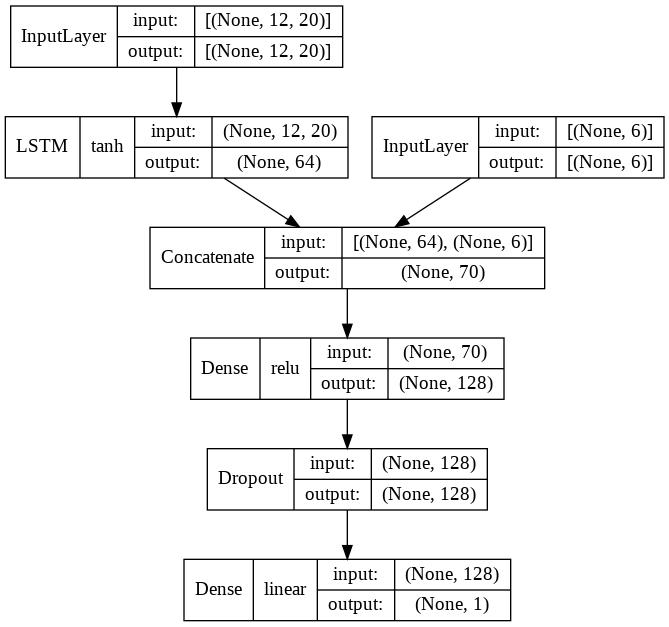

In [ ]:
def get_model_4():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.LSTM(units = 64)(input_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'LSTM_two_inputs')

  return model

model_4 = get_model_4()

tf.keras.utils.plot_model(model_4, show_shapes = True, show_layer_activations = True, show_layer_names = False)

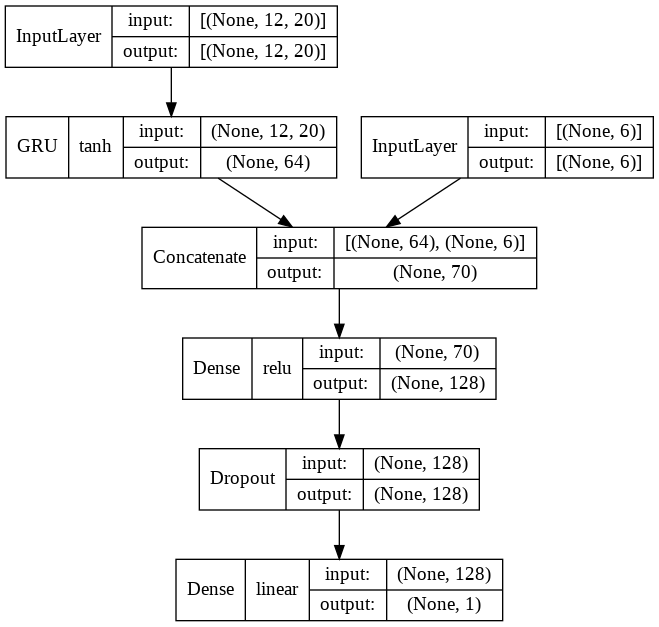

In [ ]:
def get_model_5():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.GRU(units = 64)(input_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'GRU_two_inputs')

  return model

model_5 = get_model_5()

tf.keras.utils.plot_model(model_5, show_shapes = True, show_layer_activations = True, show_layer_names = False)

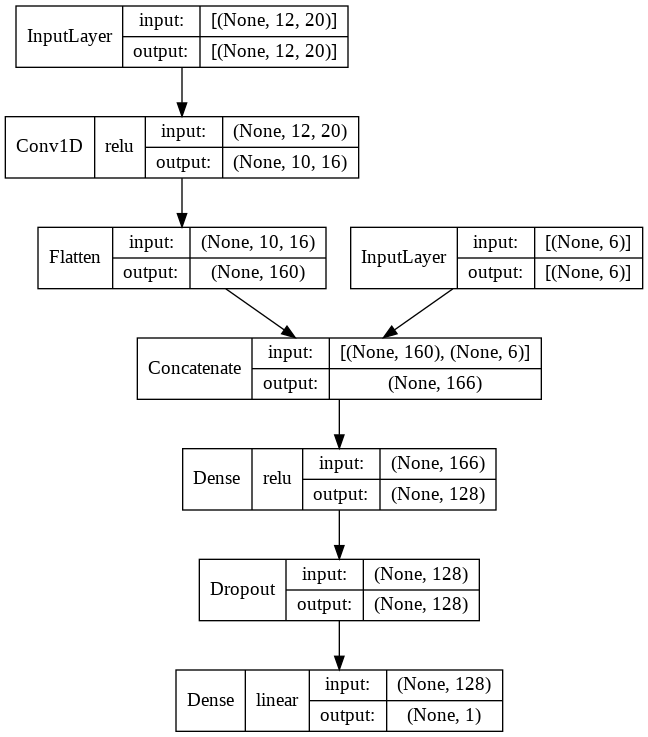

In [ ]:
def get_model_6():
  
  input_1 = tf.keras.Input(shape=(12,20), name = 'input_1')
  input_2 = tf.keras.Input(shape=(6), name = 'input_2')
  
  x_1 = tfl.Conv1D(filters = 16, kernel_size = 3, activation = 'relu')(input_1)

  x_1 = tfl.Flatten()(x_1)

  concat = tfl.concatenate([x_1, input_2], axis = 1)

  x_2 = tfl.Dense(units = 128, activation = 'relu')(concat)
  x_2 = tfl.Dropout(0.3)(x_2)

  output = tfl.Dense(units = 1, activation='linear')(x_2)

  model = tf.keras.Model(inputs=[input_1,input_2], outputs=output, name = 'Conv1D_two_inputs')

  return model

model_6 = get_model_6()

tf.keras.utils.plot_model(model_6, show_shapes = True, show_layer_activations = True, show_layer_names = False)

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/dados/train_clean.pkl')

In [ ]:
# Cria as variáveis do Input 2

selected_columns = [
                    'day_sin',
                    'day_cos',
                    'year_sin',
                    'year_cos',
                    'azimuth_sin', 
                    'azimuth_cos',
                    ]

data_train_time = select_columns(data_train, selected_columns)
data_test_time = select_columns(data_test, selected_columns)

data_train_time = data_train_time.values
data_test_time = data_test_time.values

print("Train data shape: {}".format(data_train_time.shape))
print("Test array data: {}".format(data_test_time.shape))

model = tf.keras.models.load_model('/content/drive/MyDrive/TCC Data Science/models/model_6')
mdl_test_score , test_predictions, test_true = model_score(model, [X_test, data_test_time], y_test, scaler_y)

test_true = np.reshape(test_true, -1)
test_predictions = np.reshape(test_predictions, -1)

results = {'true_values':test_true, 'predictions':test_predictions}

df_model_results = pd.DataFrame(results)

fig = go.Figure()
fig.update_layout(template = 'simple_white')
fig.add_trace(go.Scatter(x = df_model_results.index[0:291], y = df_model_results.loc[0:291, 'true_values'], name = 'Valores Observados'))
fig.add_trace(go.Scatter(x = df_model_results.index[0:291], y = df_model_results.loc[0:291, 'predictions'], name = 'Valores Previstos'))
fig.update_xaxes(title_text = 'Data - Horário', showgrid=True, mirror=True, ticks='outside',showline=True, tickmode = 'array', tickvals = [0, 50, 100, 150, 200, 250], ticktext = ["01/11 07:00", "01/11 15:20", "02/11 14:00", "03/11 12:40", "04/11 11:20", "05/11 10:00"])
fig.update_yaxes(title_text = 'Irradiância Solar Global', showgrid=True, mirror=True, ticks='outside',showline=True)
fig.show()

Train data shape: (21969, 6)
Test array data: (3267, 6)
103/103 [==============================] - 1s 3ms/step
Mean Absolute Error: 53.86


In [ ]:
df_g = pd.read_pickle('/content/drive/MyDrive/TCC Data Science/dados/train_clean.pkl')
label = {'date': 'Horário', 'irradiation':'Irradiancia Solar Global'}

mask = (df_g['month_day'] == "1/3")
df_g_day = df_g[mask]

fig = px.line(data_frame = df_g_day, x = 'date', y = 'irradiation', labels = label, template='simple_white', markers = True, width = 700)
fig.update_xaxes(showgrid=True, mirror=True, ticks='outside',showline=True, tickformat="%H:%M\n%d %b")
fig.update_yaxes(showgrid=True, mirror=True, ticks='outside',showline=True)
fig.update_traces(line_color='#f08a05')
